In [ ]:
# for Google Colab

from google.colab import drive
import os
drive.mount('/content/drive', force_remount=True)
os.chdir('/content/drive/MyDrive/c_sc/Project/programm')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
import cv2
import os
from os import listdir
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from timeit import default_timer as timer

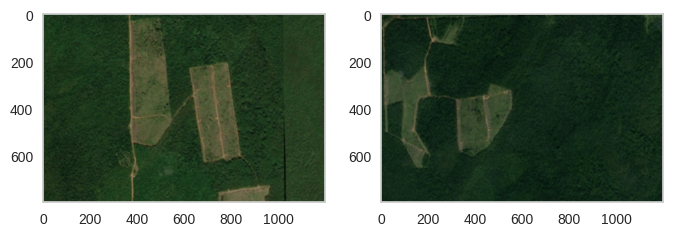

In [ ]:
# Import images chosen to be the train data

image_folder = r'data_train/'
images = []
for filename in sorted(listdir(image_folder)):
    img = cv2.imread((os.path.join(image_folder, filename)))
    if img is not None:
        img = cv2.medianBlur(img, 7)
        images.append(img)

fig, ax = plt.subplots(1, 2)
ax[0].grid(False)
ax[0].imshow(images[0][:,:,::-1])
ax[1].grid(False)
ax[1].imshow(images[1][:,:,::-1]);

In [ ]:
XX = [] # list of lists that are images
for i in images:
    height = i.shape[0]
    width = i.shape[1]
    ordered_positions = np.array(np.meshgrid(np.arange(height), np.arange(width))).T.reshape(-1, 2)

    X = []
    for j in ordered_positions:
        X.append(i[j[0], j[1], ::])

    X = np.array(X, copy=False)
    XX.append(X)

In [ ]:
# Elbow method

model_elb = KMeans(random_state=0, n_init="auto")
visualizer = KElbowVisualizer(model_elb, k=(2, 10), timings=False)
visualizer.fit(XX[0])
visualizer.poof();

In [ ]:
# K-means clustering
num_clusters = 2  # cluster quantity

predictions_all = []

for i in XX:

    model = KMeans(n_clusters=num_clusters, init='k-means++', max_iter=300, random_state=2, n_init=1).fit(i)
    labels = model.labels_

    # Transform retrieved data into image like form for visualisation and following labeling

    predictions_map = np.zeros(labels.shape).reshape(height, width)
    for (y, x), pred in zip(ordered_positions, labels):
        predictions_map[y, x] = pred

    predictions_all.append(predictions_map)

predictions_map = np.concatenate((predictions_all[0], predictions_all[1]), axis=0)

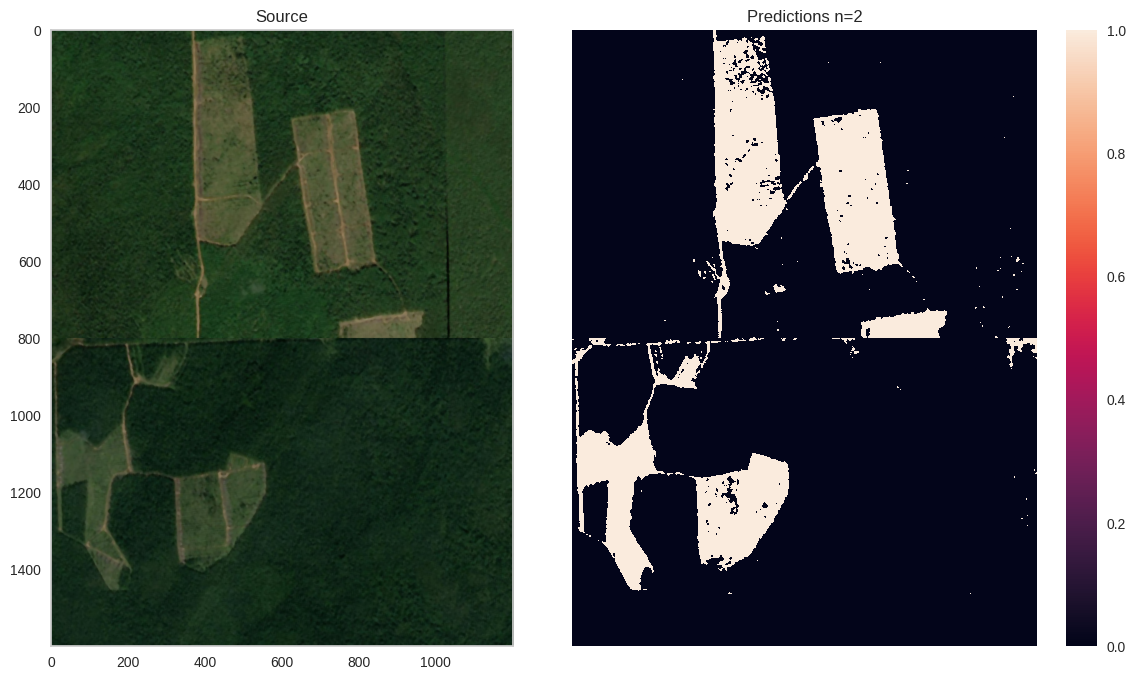

In [ ]:
# Visual analysis
img_conc = np.concatenate((images[0], images[1]), axis=0)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 8))
ax1.imshow(img_conc[:,:,::-1]); #img_rgb
sns.heatmap(predictions_map, ax=ax2)
ax1.grid(False)
ax1.set_title('Source')
ax2.axis('off')
ax2.set_title(f'Predictions n={num_clusters}')
plt.subplots_adjust(wspace=0);

In [ ]:
d = {'0': 'background',
    '1': 'damaged forest',
    }
regions = pd.Series(d)
print(regions)
print('classes -', np.unique(predictions_map))
type(predictions_map), predictions_map.shape

С помощью библиотеки OpenCV произведем операции эрозии и дилатации.

In [ ]:
# Creating Deforested area class mask
mask = predictions_map.copy()
mask[mask == 1] = 255
mask = np.uint8(mask)

In [ ]:
# Erosion and dilation functions

def erode(mask, kernel_val=3, iters=1):
    kernel = np.ones((kernel_val, kernel_val), np.uint8)
    mask = cv2.erode(mask, kernel, iterations=iters)
    eroded_mask = mask.copy()
    return eroded_mask

def dilate(mask, kernel_val=3, iters=1):
    kernel = np.ones((kernel_val, kernel_val), np.uint8)
    dilated_mask = cv2.dilate(mask, kernel, iterations=iters)
    return dilated_mask

In [ ]:
# Manual mask modifying with erosion and dilation operations

img_gray = cv2.cvtColor(img_conc, cv2.COLOR_BGR2GRAY)

def nothing(x):
    pass

cv2.namedWindow('controls', cv2.WINDOW_NORMAL)
cv2.createTrackbar('erode_matr', 'controls', 3, 10, nothing)
cv2.createTrackbar('erode_itr', 'controls', 0, 10, nothing)
cv2.createTrackbar('dilate_matr', 'controls', 3, 10, nothing)
cv2.createTrackbar('dilate_itr', 'controls', 0, 10, nothing)
cv2.createTrackbar('erode_matr_1', 'controls', 3, 10, nothing)
cv2.createTrackbar('erode_itr_1', 'controls', 0, 10, nothing)
cv2.createTrackbar('dilate_matr_1', 'controls', 3, 10, nothing)
cv2.createTrackbar('dilate_itr_1', 'controls', 0, 10, nothing)

while(1):

    e_matr = int(cv2.getTrackbarPos('erode_matr', 'controls'))
    e_itr = int(cv2.getTrackbarPos('erode_itr', 'controls'))
    d_matr = int(cv2.getTrackbarPos('dilate_matr', 'controls'))
    d_itr = int(cv2.getTrackbarPos('dilate_itr', 'controls'))
    e_matr_1 = int(cv2.getTrackbarPos('erode_matr_1', 'controls'))
    e_itr_1 = int(cv2.getTrackbarPos('erode_itr_1', 'controls'))
    d_matr_1 = int(cv2.getTrackbarPos('dilate_matr_1', 'controls'))
    d_itr_1 = int(cv2.getTrackbarPos('dilate_itr_1', 'controls'))

    mask_res_1 = erode(mask, kernel_val=e_matr, iters=e_itr)
    mask_res_2 = dilate(mask_res_1, d_matr, d_itr)
    mask_res_3 = erode(mask_res_2, e_matr_1, e_itr_1)
    mask_res_4 = dilate(mask_res_3, d_matr_1, d_itr_1)

    mask_res_4_inv = cv2.bitwise_not(mask_res_4)

    img_new = cv2.bitwise_and(img_conc, img_conc, mask=mask_res_4)
    img_gray_new = cv2.bitwise_and(img_gray, img_gray, mask=mask_res_4_inv)

    out = cv2.add(img_new, cv2.cvtColor(img_gray_new, cv2.COLOR_GRAY2BGR))

    contours, hierarchy = cv2.findContours(mask_res_4_inv, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    cv2.drawContours(out, contours, -1, (0, 0, 255), 1)

    text = f'contours q-ty = {str(len(contours))}'
    fontScale = 1
    fontFace = cv2.FONT_HERSHEY_COMPLEX
    fontColor = (0, 255, 0)
    fontThickness = 2
    cv2.putText(out, text, (0, 60), fontFace, fontScale, fontColor, fontThickness, cv2.LINE_AA);

    cv2.namedWindow('img_d', cv2.WINDOW_NORMAL)
    cv2.namedWindow('out', cv2.WINDOW_NORMAL)
    cv2.imshow('img_d', mask_res_4)
    cv2.imshow('out', out)

    k = cv2.waitKey(1) & 0xFF
    if k == 27:
        break

cv2.destroyAllWindows()
cv2.waitKey(1)

-1

In [ ]:
# The alternative way of clustering by track bars at HSV color space

img_track = cv2.imread(r'data_train/1image1.JPG')
img_track = cv2.medianBlur(img_track, 7)
img_hsv = cv2.cvtColor(img_track, cv2.COLOR_BGR2HSV)

def nothing(x):
    pass

cv2.namedWindow('controls', cv2.WINDOW_NORMAL)
cv2.createTrackbar('H_lower','controls', 0, 179, nothing)
cv2.createTrackbar('S_lower','controls', 0, 255, nothing)
cv2.createTrackbar('V_lower','controls', 0, 255, nothing)
cv2.createTrackbar('H_upper','controls', 0, 179, nothing)
cv2.createTrackbar('S_upper','controls', 0, 255, nothing)
cv2.createTrackbar('V_upper','controls', 0, 255, nothing)

while(1):

    H_l = int(cv2.getTrackbarPos('H_lower', 'controls'))
    H_u = int(cv2.getTrackbarPos('H_upper', 'controls'))
    S_l = int(cv2.getTrackbarPos('S_lower', 'controls'))
    S_u = int(cv2.getTrackbarPos('S_upper', 'controls'))
    V_l = int(cv2.getTrackbarPos('V_lower', 'controls'))
    V_u = int(cv2.getTrackbarPos('V_upper', 'controls'))

    lower = np.array([H_l, S_l, V_l])
    upper = np.array([H_u, S_u, V_u])

    mask = cv2.inRange(img_hsv, lower, upper)

    cv2.namedWindow('mask', cv2.WINDOW_NORMAL)
    cv2.imshow('mask', mask)

    k = cv2.waitKey(1) & 0xFF
    if k == 27:
        break

cv2.destroyAllWindows()
cv2.waitKey(1)

-1

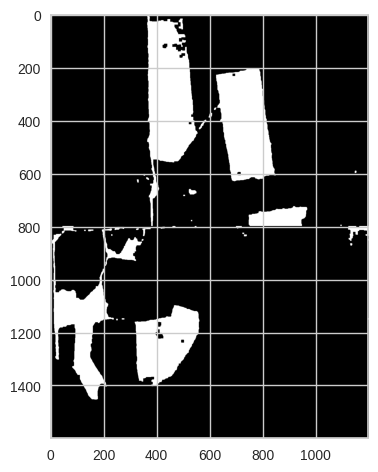

In [ ]:
# Modified mask is saved to file
# np.save('mask_2tp_morph.npy', mask_res_4)
pred_map = np.load('mask_2tp_morph.npy')  # load mask
plt.imshow(pred_map, 'gray');

In [ ]:
# Changing labels shape

pred_map[pred_map == 255] = 1
np.unique(pred_map)

X = np.concatenate((XX[0], XX[1]), axis=0)

height_1 = img_conc.shape[0] #сдвоенное изобр
width_1 = img_conc.shape[1]
ordered_positions_1 = np.array(np.meshgrid(np.arange(height_1), np.arange(width_1))).T.reshape(-1, 2)

labels_new = []
for i in ordered_positions_1:
    labels_new.append(pred_map[i[0], i[1]])
labels_new = np.array(labels_new, copy=False)
print(labels_new.shape), print(X.shape)

(1920000,)
(1920000, 3)


(None, None)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

scaler = MinMaxScaler()
X = scaler.fit_transform(X)         # data normalization

In [ ]:
# Evaluating the quality of the models predictions:

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

classifiers = [MLPClassifier(max_iter=200), GaussianNB(), KNeighborsClassifier(n_neighbors=3)]
evaluation_dict_all = []

X_train, X_test, labels_train, labels_test = train_test_split(X, labels_new, test_size=0.3, random_state = True, shuffle=True)

for classifier in classifiers:

    start = timer()
    model = classifier
    model.fit(X_train, labels_train)
    labels_pred = model.predict(X_test)
    end = timer()
    print(end - start)

    cm = confusion_matrix(labels_test, labels_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)

    score = model.score(X_test, labels_test)
    print(score)

    TN = cm[0][0]
    FP = cm[0][1]
    FN = cm[1][0]
    TP = cm[1][1]

    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    # Specificity or true negative rate
    TNR = TN/(TN+FP)
    # Precision or positive predictive value
    PPV = TP/(TP+FP)
    # Negative predictive value
    NPV = TN/(TN+FN)
    # Fall out or false positive rate
    FPR = FP/(FP+TN)
    # False negative rate
    FNR = FN/(TP+FN)
    # False discovery rate
    FDR = FP/(TP+FP)
    # F1 metric
    F1 = 2 * ((PPV * TPR) / (PPV + TPR))
    # Overall accuracy
    ACC = (TP+TN)/(TP+FP+FN+TN)

    evaluation_dict = {'FP': FP,
                       'FN': FN,
                       'TP': TP,
                       'TN': TN,
                       'TPR': TPR,
                       'TNR': TNR,
                       'PPV': PPV,
                       'NPV': NPV,
                       'FPR': FPR,
                       'FNR': FNR,
                       'FDR': FDR,
                       'F1': F1,
                       'ACC/Score': ACC
                       }

    evaluation_dict_all.append(evaluation_dict)

    disp.plot(cmap='Blues')
    plt.grid(False)

In [ ]:
# Learning the classifier with fool train data


#cls = MLPClassifier(max_iter=200)
#cls.fit(X, labels_new)
#joblib.dump(cls, 'MLP_2cl_morph_nrml.pkl') # save the trained model to file
cls = joblib.load('MLP_2cl_morph_nrml.pkl')

In [ ]:
cls = KNeighborsClassifier(n_neighbors=3)
cls.fit(X, labels_new)

KNeighborsClassifier(n_neighbors=3)

In [ ]:
cls = GaussianNB()
cls.fit(X, labels_new)

GaussianNB()

In [ ]:
# Process the whole dataset

image_folder = r'data/'
images = []
for filename in listdir(image_folder):
    img = cv2.imread(os.path.join(image_folder, filename))
    if img is not None:
        images.append(img)

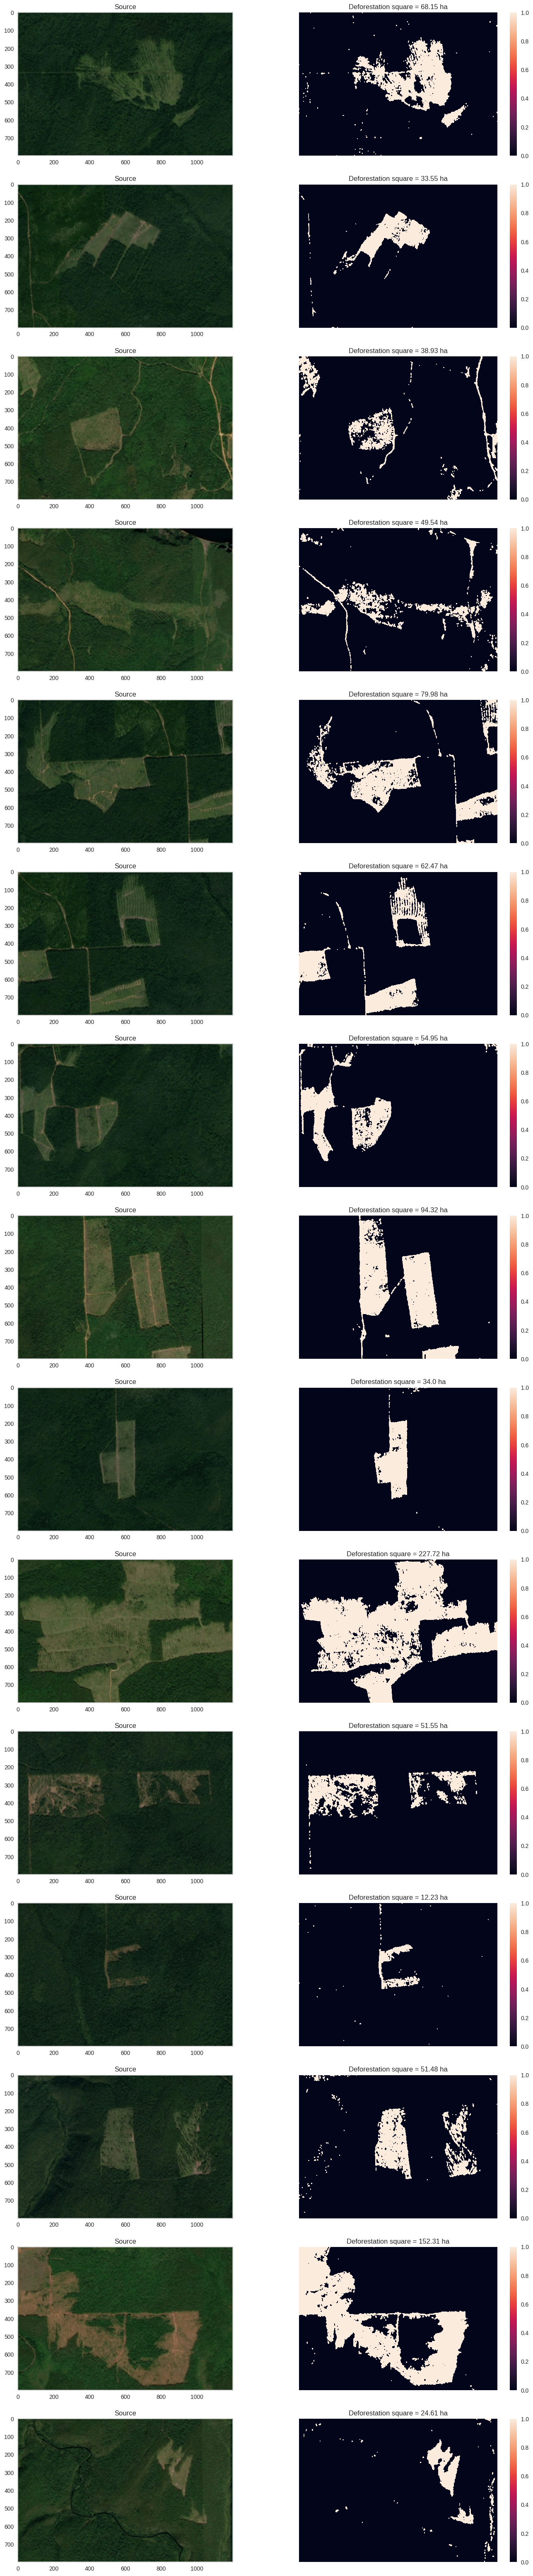

KNeighborsClassifier, time:1347.26, total square:1035.79ha


In [ ]:
start = timer()
j = 1
k = 2
square = []
predictions_map_test_all = []

fig = plt.figure(figsize=(17, 80))

for image in images:
    ax = fig.add_subplot(15, 2, j)
    ax1 = fig.add_subplot(15, 2, k)

    img_2 = image
    assert img_2 is not None, ('not found')
    height = img_2.shape[0]
    width = img_2.shape[1]
    img_2  = cv2.medianBlur(img_2, 7)
    ordered_positions_2 = np.array(np.meshgrid(np.arange(height), np.arange(width))).T.reshape(-1, 2)
    X_2 = []
    for i in ordered_positions_2:
        X_2.append(img_2[i[0], i[1], ::])
    X_2 = np.array(X_2, copy=False)

    X_2 = scaler.fit_transform(X_2)
    labels_test = cls.predict(X_2)

    predictions_map_test = np.zeros(labels_test.shape).reshape(height, width)
    for (y, x), pred in zip(ordered_positions_2, labels_test):
        predictions_map_test[y, x] = pred

    kernel = np.ones((5, 5), np.uint8)

    predictions_map_test = cv2.morphologyEx(predictions_map_test, cv2.MORPH_OPEN, kernel, iterations = 1)
    #predictions_map_test = cv2.morphologyEx(predictions_map_test, cv2.MORPH_CLOSE, kernel, iterations = 1)

    ax.imshow(img_2[:,:,::-1])
    ax.set_title('Source')
    ax.grid(False)

    predictions_map_test_all.append(predictions_map_test)
    sns.heatmap(predictions_map_test, ax=ax1)

    n = (predictions_map_test == 1).sum()
    n = round(n*0.0005948, 2)      # computing the deforested square
    square.append(n)

    ax1.axis('off')
    ax1.set_title(f'Deforestation square = {n} ha');

    j += 2
    k += 2

plt.show()
end = timer()
time = round(end - start, 2)
total_square = round(sum(square), 2)
print(f'{cls.__class__.__name__}, time:{time}, total square:{total_square}ha')
